In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float
    bpb: float
    boundary_percent: float
    summary: str

# 1. Validation node
def validate_boundaries(state: BatsmanState) -> BatsmanState:
    try:
        total_boundary_runs = state['fours'] * 4 + state['sixes'] * 6
        if total_boundary_runs > state['runs']:
            raise ValueError(
                f"Invalid stats: boundary runs ({total_boundary_runs}) "
                f"exceed total runs ({state['runs']})"
            )
    except Exception as e:
        raise e
        
    return state

# 2. Calculation nodes (fixed minor bugs)
def calculate_sr(state: BatsmanState) -> BatsmanState:
    sr = (state['runs'] / state['balls']) * 100
    return {'sr':sr}

def calculate_bpb(state: BatsmanState) -> BatsmanState:
    bpb = state['fours'] + state['sixes']
    return {'bpb':bpb}

def calculate_boundary_percent(state: BatsmanState) -> BatsmanState:
    boundary_percent = state['fours'] * 4 + state['sixes'] * 6
    return {'boundary_percent':boundary_percent}

def summary(state: BatsmanState) -> BatsmanState:
    state['summary'] = (
        f"Strike Rate – {state['sr']}%\n"
        f"Balls Per Boundary – {state['bpb']}\n"
        f"Boundary % – {state['boundary_percent']}%"
    )
    return state
    
# 3. Build the graph
graph = StateGraph(BatsmanState)

graph.add_node('validate_boundaries', validate_boundaries)
graph.add_node('calculate_sr', calculate_sr)
graph.add_node('calculate_bpb', calculate_bpb)
graph.add_node('calculate_boundary_percent', calculate_boundary_percent)
graph.add_node('summary', summary)

# 4. Wire up edges
graph.add_edge(START, 'validate_boundaries')

# Only if validation passes do we branch into the three metrics
graph.add_edge('validate_boundaries', 'calculate_sr')
graph.add_edge('validate_boundaries', 'calculate_bpb')
graph.add_edge('validate_boundaries', 'calculate_boundary_percent')

# Converge into summary
graph.add_edge('calculate_sr', 'summary')
graph.add_edge('calculate_bpb', 'summary')
graph.add_edge('calculate_boundary_percent', 'summary')

graph.add_edge('summary', END)

workflow = graph.compile()

# 5. Execute
initial_state: BatsmanState = {
    "runs": 100,
    "balls": 36,
    "fours": 4,
    "sixes": 8}

print(workflow.invoke(initial_state))

{'runs': 100, 'balls': 36, 'fours': 4, 'sixes': 8, 'sr': 277.77777777777777, 'bpb': 12, 'boundary_percent': 64, 'summary': 'Strike Rate – 277.77777777777777%\nBalls Per Boundary – 12\nBoundary % – 64%'}


### Visualizing the WorkFlow

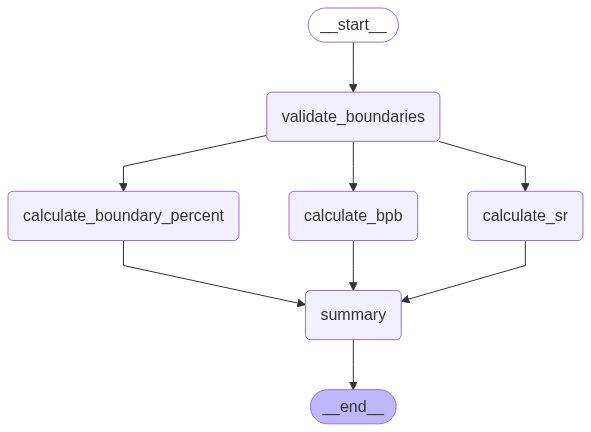

In [13]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())